In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import pprint

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pp = pprint.PrettyPrinter(indent=4)

In [2]:
def print_full(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')

### Load the data.

In [64]:
dfa = pd.read_excel('GA Tech (Active - Inactive Service Contracts, CRM Service Oppty).xlsx', sheet_name = 'Active Service Contracts', parse_dates=True)

In [65]:
dfb = pd.read_excel('GA Tech (Active - Inactive Service Contracts, CRM Service Oppty).xlsx', sheet_name = 'Inactive Service Contracts', parse_dates=True)

### Concatenate.

In [143]:
# active and inactive data together
df = pd.concat([dfa, dfb], axis = 0)
df.head()
df.shape

(564487, 71)

### Reformat and Clean Data.

In [144]:
# format dates
df.replace(to_replace='05/01/0219', value = '2019-05-01', inplace = True)
df.replace(to_replace='2319', value = '2019', inplace = True)

In [145]:
df['Contract Header Start Date ID'] = pd.to_datetime(df['Contract Header Start Date ID'], format = '%Y-%m-%d')
df['Contract Header End Date'] = pd.to_datetime(df['Contract Header End Date'], format = '%Y-%m-%d', errors = 'coerce')
df['Contract Line Start Date'] = pd.to_datetime(df['Contract Line Start Date'], format = '%Y-%m-%d')
df['Contract Line End Date'] = pd.to_datetime(df['Contract Line End Date'], format = '%Y-%m-%d')
df['Contract Subline Start Date'] = pd.to_datetime(df['Contract Subline Start Date'], format = '%Y-%m-%d')
df['Contract Subline End Date'] = pd.to_datetime(df['Contract Subline End Date'], format = '%Y-%m-%d')

In [146]:
# binary categorical variable for contract status
df['Contract Status'] = df['Contract Status'].replace({'Active':0, 'Inactive':1})
df.head()


,Contract Status,Region DESC,Branch ID,Unit Type DESC,Unit Subtype DESC,Controller Motor OEM ID,Contract Header Start Date ID,Contract Header End Date,Contract Line Start Date,Contract Line End Date,...,NB Repair RT OVH Cost,OT Labor Hours,Repair OT DL Cost,Repair OT Hours,Repair OT OVH Cost,Repair RT DL Cost,Repair RT Hours,Repair RT OVH Cost,RT Labor Hours,Total Labor Hours
0,0,ACQUISITIONS,345,ELEVATOR,EL HYDRAULIC,NaN,2012-03-01,2023-02-28,2012-03-01,2023-02-28,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00
1,0,CALIFORNIA,28,ELEVATOR,EL HYDRAULIC,NaN,2004-07-01,2021-06-30,2004-07-01,2021-06-30,...,150.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.30,28.30
2,0,CALIFORNIA,28,ELEVATOR,EL HYDRAULIC,NaN,2004-07-01,2021-06-30,2004-07-01,2021-06-30,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.00,3.00
3,0,CALIFORNIA,28,ELEVATOR,EL HYDRAULIC,NaN,2004-07-01,2021-06-30,2004-07-01,2021-06-30,...,0.0,0.0,0.0,0.0,0.0,178.0,3.0,448.0,2.75,2.75
4,0,CALIFORNIA,28,ELEVATOR,EL HYDRAULIC,NaN,2004-07-01,2021-06-30,2004-07-01,2021-06-30,...,355.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.75,33.75


### NaN Values.

In [147]:
# table (nasdf) that shows # of NaN per column AND % NaN of total
nas = df.isna().sum()
nasdf = nas.to_frame()
nasdf.columns = ['NaN Count']

nasdf['NaN Percent'] = round((nasdf['NaN Count'] / 564487)*100, 3)

In [148]:
n25= len(nasdf[nasdf['NaN Count'] == 125])
ntot= len(nasdf)

print(f'Out of {ntot} rows, {n25} of them contain a NaN count = 125. \n{round((n25/ntot)*100, 2)}% of NaN counts that are greater than 0 are 125.')

Out of 71 rows, 48 of them contain a NaN count = 125. 
67.61% of NaN counts that are greater than 0 are 125.


In [149]:
# filter NaN percents above 0.1%
thresh = nasdf['NaN Percent'] > .1
nasdf_thresh = nasdf[thresh].sort_values(by=['NaN Percent'], ascending = False)
nasdf_thresh

,NaN Count,NaN Percent
Controller Motor OEM ID,563836,99.885
Contract Term Years ID,48711,8.629
Opportunity No ID,46219,8.188
Gross Margin %,35242,6.243
Rear/Side Openings # ID,16654,2.950
Controller Model ID,10511,1.862
Floor Total ID,8304,1.471
Speed FPM ID,5541,0.982
Capacity LBS ID,4153,0.736
Front Openings # ID,3931,0.696


In [150]:
## Drop column from OG df where NaN is greater than 5%
todrop = nasdf_thresh[nasdf_thresh['NaN Percent'] > 5].index

droplist = []
for i in todrop:
    droplist.append(i)
droplist 

df.drop(columns = droplist, inplace = True)

In [151]:
# see if we need to delete any NaN rows:
nas = df.isna().sum()
nasdf = nas.to_frame()
nasdf.columns = ['NaN Count']

nasdf['NaN Percent'] = round((nasdf['NaN Count'] / 564487)*100, 3)
thresh = nasdf['NaN Percent'] > 0
nasdf_thresh = nasdf[thresh].sort_values(by=['NaN Percent'], ascending = False)
print_full(nasdf_thresh)

                          NaN Count          NaN Percent
Rear/Side Openings # ID       16654                 2.95
Controller Model ID           10511                 1.86
Floor Total ID                 8304                 1.47
Speed FPM ID                   5541                 0.98
Capacity LBS ID                4153                 0.74
Front Openings # ID            3931                 0.70
Total Labor Hours               145                 0.03
Maintenance RT DL Cost          125                 0.02
NB Repair OT OVH Cost           125                 0.02
Maintenance OT OVH Cost         125                 0.02
Maintenance RT Hours            125                 0.02
Maintenance RT OVH Cost         125                 0.02
Material Cost                   125                 0.02
NB Callback OT Qty              125                 0.02
NB Callback RT Qty              125                 0.02
NB Repair OT DL Cost            125                 0.02
NB Repair OT Hours             

In [152]:
df_dropped = df.dropna()

In [153]:
len(df_dropped) # number of rows

534813

In [154]:
df = df_dropped

### Calculate number of days between dates.

In [155]:
df_times = df


df_times[['Contract Header Length (days)']] = (df_times['Contract Header End Date'] - df_times['Contract Header Start Date ID']).dt.days
df_times[['Contract Line Length (days)']] = (df_times['Contract Line End Date'] - df_times['Contract Line Start Date']).dt.days
df_times[['Contract Subline Length (days)']] = (df_times['Contract Subline End Date'] - df_times['Contract Subline Start Date']).dt.days

In [156]:
df = df_times

In [157]:
## check correlation
corr = df.corr().abs()
mat = np.triu(corr)


# set equality (self correlation) as zero
corr[corr == 1] = 0

corr_cols = corr.max().sort_values(ascending=False)
# display the highly correlated features
res = (corr_cols[corr_cols > 0.8])
print_full(res)

Contract Subline Length (days)                   1.00
Contract Line Length (days)                      1.00
Maintenance OT OVH Cost                          1.00
Maintenance OT Hours                             1.00
Extras OT OVH Cost                               0.99
Extras OT Hours                                  0.99
Repair OT OVH Cost                               0.99
Repair OT DL Cost                                0.99
Extras RT OVH Cost                               0.99
Extras RT Hours                                  0.99
Callback OT Hours                                0.99
Callback OT OVH Cost                             0.99
Extras OT DL Cost                                0.99
NB Repair OT DL Cost                             0.99
NB Repair OT OVH Cost                            0.99
Callback RT OVH Cost                             0.99
Callback RT Hours                                0.99
NB Repair RT DL Cost                             0.99
NB Repair RT OVH Cost       

<AxesSubplot:>

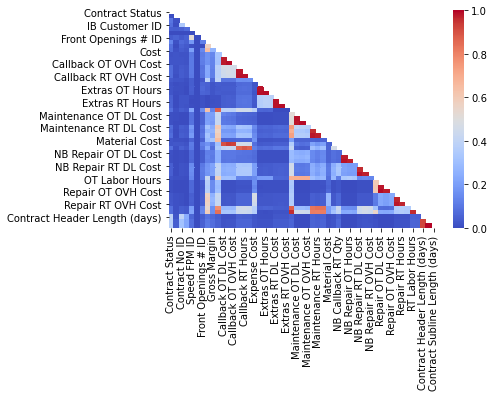

In [158]:
sns.heatmap(corr, mask = mat, vmin = 0, vmax = 1, center = 0.5, cmap = 'coolwarm')

In [159]:
correlated_features = set()
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > 0.8:
            colname = corr.columns[i]
            correlated_features.add(colname)
print(correlated_features)


{'Maintenance OT OVH Cost', 'Total Labor Hours', 'NB Repair OT OVH Cost', 'NB Callback OT Qty', 'Labor incl OH', 'NB Repair RT OVH Cost', 'Maintenance OT Hours', 'Maintenance RT OVH Cost', 'Contract Subline Length (days)', 'Callback RT Hours', 'NB Repair RT Hours', 'Repair OT Hours', 'Callback OT OVH Cost', 'Repair OT OVH Cost', 'Maintenance RT Hours', 'Repair RT OVH Cost', 'Callback RT OVH Cost', 'Extras RT OVH Cost', 'Contract Line Length (days)', 'Repair RT Hours', 'NB Callback RT Qty', 'Extras OT Hours', 'Extras RT Hours', 'Callback OT Hours', 'RT Labor Hours', 'Extras OT OVH Cost', 'NB Repair OT Hours'}


In [160]:
# drop highly correlated features
df.drop(labels = correlated_features, axis = 1, inplace = True)

### Create categorical variables.

In [161]:
idcols = [col for col in df.columns if "ID" in col]

print(idcols)

for i in idcols:
    df[[i]] = df[[i]].astype(str)
    df[[i]] = df[[i]].astype('category')
idcols.append('Route No')

['Branch ID', 'Contract Header Start Date ID', 'Contract No ID', 'Controller Model ID', 'IB Customer ID', 'Speed FPM ID', 'Capacity LBS ID', 'Floor Total ID', 'Front Openings # ID', 'Rear/Side Openings # ID', 'Unit ID']


### Reduce Noise and Clean Data

In [162]:
todrop = []
for col in idcols:
    x = df[col].nunique()
    print(f'{col}: {x}')
    if x > 400:
        todrop.append(col)

Branch ID: 121
Contract Header Start Date ID: 3210
Contract No ID: 128430
Controller Model ID: 248
IB Customer ID: 86660
Speed FPM ID: 74
Capacity LBS ID: 113
Floor Total ID: 83
Front Openings # ID: 80
Rear/Side Openings # ID: 112
Unit ID: 245190
Route No: 470


In [163]:
## drop cols with too much noise from above
print(todrop)
df.drop(columns = todrop, inplace = True)

['Contract Header Start Date ID', 'Contract No ID', 'IB Customer ID', 'Unit ID', 'Route No']


In [164]:
## Fix two ID column Data
df['Rear/Side Openings # ID'] = df['Rear/Side Openings # ID'].str.replace('.0', '', regex= True)
df['Capacity LBS ID'] = df['Capacity LBS ID'].str.replace('.0', '', regex= True)


In [165]:
## Drop Rows with Negative Lengths:
df.drop(df[df['Contract Header Length (days)'] <= 0].index, inplace=True)


In [166]:
# Bin Header Lengths
df['Contract Header Length (days)'] = pd.cut(df['Contract Header Length (days)'], bins = 100, include_lowest = True)
df['Contract Header Length (days)'].value_counts()
# Bin Revenue
df['Revenue'] = pd.cut(df['Revenue'], bins = 1000, include_lowest = True)
df['Revenue'].value_counts()
# Bin Cost
df['Cost'] = pd.cut(df['Cost'], bins = 1000, include_lowest = True)
df['Cost'].value_counts()
# Bin Maintenance RT DL Cost
df['Maintenance RT DL Cost'] = pd.cut(df['Maintenance RT DL Cost'], bins = 200, include_lowest = True)

In [167]:
df[df.select_dtypes(['object']).columns] = df.select_dtypes(['object']).apply(lambda x: x.astype('category'))
df['Contract Header Length (days)'] = df['Contract Header Length (days)'].astype('category')
df['Revenue'] = df['Revenue'].astype('category')
df['Cost'] = df['Cost'].astype('category')
df['Maintenance RT DL Cost'] = df['Maintenance RT DL Cost'].astype('category')

In [168]:
# drop start / end date cols and just keep the amt of time cols
todrop = ['Contract Header End Date', 'Contract Subline Start Date', 'Contract Subline End Date', 'Contract Line Start Date', 'Contract Line End Date']
df.drop(columns = todrop, inplace = True)

In [169]:
df[df.select_dtypes(['datetime64[ns]']).columns] = df.select_dtypes(['datetime64[ns]']).apply(lambda x: x.astype('category'))

#### Drop Rows Where Coverage Type = NIM
*per tkE request* -- see what factors are relevant without NIM (since NIM generally just means not yet updated)

In [171]:
indexNames = df[df['Coverage Type DESC'] == 'NIM'].index

df.drop(indexNames, inplace = True)

In [172]:
df.shape

(455108, 33)

In [173]:
not_encoded_copy = df.copy()

#### Encode

In [174]:
# Encode Categorical Columns
le = LabelEncoder()

toEncode = df.select_dtypes(include = "category").columns

dictEncode = {}

for col in toEncode:
    dictEncode[col] = LabelEncoder().fit(df[col])

for col in toEncode:
    df[col] = dictEncode[col].transform(df[col])



In [175]:
encoded = df

In [176]:
encoded.drop(columns = ['Gross Margin'], inplace = True)

In [177]:
encoded.shape

(455108, 32)

### Split the data.
Dependent vs Independent  
Train vs Test

In [178]:
ys = encoded[['Contract Status']]
xs = encoded.loc[:, encoded.columns != 'Contract Status']


In [179]:
headers = xs.columns.values
x_tr, x_te, y_tr, y_te = train_test_split(xs, ys, test_size = 0.2, random_state=123)

#### Initial Random Forest Model

In [180]:
## Random Forest Classification for Feature Importance

model = RandomForestClassifier()
model.fit(x_tr, np.ravel(y_tr))
importance = model.feature_importances_
feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = x_tr.columns,
                                columns=['importance']).sort_values('importance',ascending=False)

In [181]:
partial_importances = feature_importances.head(7)

In [182]:
partial_importances

,importance
Contract Header Length (days),0.252947
Revenue,0.078273
Branch ID,0.072679
Controller Model ID,0.057748
Region DESC,0.054302
Market Segment DESC,0.046338
Unit Subtype DESC,0.035158


In [183]:
len(feature_importances)

31

<ipython-input-184-28425deb7367>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  partial_importances.sort_values('importance', inplace = True)


<AxesSubplot:>

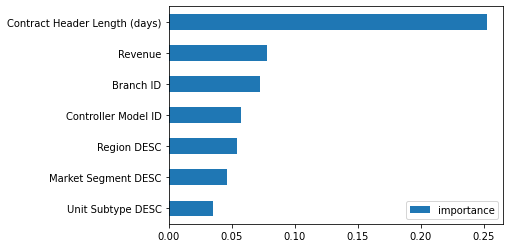

In [184]:
partial_importances.sort_values('importance', inplace = True)
partial_importances.plot.barh()

Model Test Accuracy: 93.93%
Model Train Accuracy: 99.99%


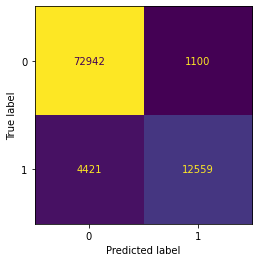

In [185]:
preds = model.predict(x_te)
tr_res = model.predict(x_tr)

tn, fp, fn, tp = confusion_matrix(y_te, preds, labels = [0, 1]).ravel()
tnr, fpr, fnr, tpr = confusion_matrix(y_tr, tr_res, labels = [0, 1]).ravel()

confusion = confusion_matrix(y_te, preds, labels = [0, 1])
ConfusionMatrixDisplay(confusion).plot(colorbar = False)

te_accuracy = (tn+tp)/(tn+fp+fn+tp) * 100
tr_accuracy = (tnr+tpr)/(tnr+fpr+fnr+tpr) * 100

print(f'Model Test Accuracy: {round(te_accuracy, 2)}%')
print(f'Model Train Accuracy: {round(tr_accuracy, 2)}%')

In [186]:
## create copy of encoder df
encoded_new = encoded.copy()

#### Updated Random Forest Model (Final)

                     importance
Branch ID              0.117273
Revenue                0.104711
Controller Model ID    0.081826
Market Segment DESC    0.058650
Speed FPM ID           0.054568
<ipython-input-187-de520048aaa3>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  partial_importances_new.sort_values('importance', inplace = True)
Model Test Accuracy: 93.93%
Model Train Accuracy: 99.99%


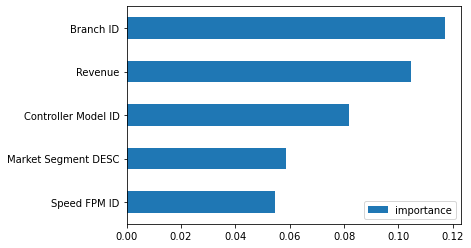

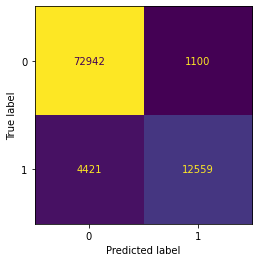

In [187]:
## run without Contract Header Length (days)
## (because more likely that longer length = active contract)

encoded_new.drop(columns = ['Contract Header Length (days)', 'Region DESC'], inplace = True)

ys_new = encoded_new[['Contract Status']]
xs_new = encoded_new.loc[:, encoded_new.columns != 'Contract Status']

headers = xs.columns.values
x_tr_new, x_te_new, y_tr_new, y_te_new = train_test_split(xs_new, ys_new, test_size = 0.2, random_state=123)


model_new = RandomForestClassifier()
model_new.fit(x_tr_new, np.ravel(y_tr_new))
importance_new = model_new.feature_importances_
feature_importances_new = pd.DataFrame(model_new.feature_importances_,
                                   index = x_tr_new.columns,
                                columns=['importance']).sort_values('importance',ascending=False)
partial_importances_new = feature_importances_new.head(5)

print(partial_importances_new)

partial_importances_new.sort_values('importance', inplace = True)
partial_importances_new.plot.barh()

preds_new = model_new.predict(x_te_new)
tr_res_new = model_new.predict(x_tr_new)

tn, fp, fn, tp = confusion_matrix(y_te, preds, labels = [0, 1]).ravel()
tnr, fpr, fnr, tpr = confusion_matrix(y_tr, tr_res, labels = [0, 1]).ravel()

confusion = confusion_matrix(y_te, preds, labels = [0, 1])
ConfusionMatrixDisplay(confusion).plot(colorbar = False)

te_accuracy = (tn+tp)/(tn+fp+fn+tp) * 100
tr_accuracy = (tnr+tpr)/(tnr+fpr+fnr+tpr) * 100

print(f'Model Test Accuracy: {round(te_accuracy, 2)}%')
print(f'Model Train Accuracy: {round(tr_accuracy, 2)}%')

### Unencode Data for Interpretation

In [215]:
def percentsTable(df, colname, threshold):
    df0 = df.loc[df['Contract Status'] == 0]
    df1 = df.loc[df['Contract Status'] == 1]

    df0_cont = df0[colname].value_counts().rename_axis('unique_values').reset_index(name='counts')
    df1_cont = df1[colname].value_counts().rename_axis('unique_values').reset_index(name='counts')

    df_cont = pd.merge(left = df0_cont, right = df1_cont, 
                         left_on = 'unique_values', right_on = 'unique_values')


    df_cont = df_cont.rename(columns={"unique_values":colname,"counts_x": "Percent of Active", "counts_y": "Percent of Inactive"})
    
    
    df_cont['Percent of Active'] = round(df_cont['Percent of Active'] / len(df0) * 100,2)
    df_cont['Percent of Inactive'] = round(df_cont['Percent of Inactive'] / len(df1) * 100,2)
    df_cont['Inactive % - Active %'] = df_cont["Percent of Inactive"] - df_cont["Percent of Active"]
    df_cont = df_cont.sort_values(by = ['Inactive % - Active %'], ascending = False)
    df
    
    result = df_cont.loc[df_cont['Inactive % - Active %'] > threshold]
    
    return result

In [192]:
# Only run this once. Once you run it, you shouldn't run it again (because there's nothing to "unencode"), unless the df has been re-encoded.
for col in toEncode:
    df[col] = dictEncode[col].inverse_transform(df[col])

### View Relevant Factors

In [216]:
percentsTable(df, 'Branch ID', 0)

,Branch ID,Percent of Active,Percent of Inactive,Inactive % - Active %
27,66,1.19,2.80,1.61
3,135,1.94,3.29,1.35
18,86,1.44,2.71,1.27
50,70,0.85,2.11,1.26
53,83,0.78,1.98,1.20
4,41,1.79,2.98,1.19
10,34,1.67,2.41,0.74
69,53,0.64,1.26,0.62
23,8,1.30,1.89,0.59
80,23,0.51,1.06,0.55


In [217]:
percentsTable(df, 'Revenue', 0)

,Revenue,Percent of Active,Percent of Inactive,Inactive % - Active %
6,"(-1430.335, 227.857]",5.58,19.60,14.02
0,"(227.857, 1886.048]",26.57,31.28,4.71
1,"(1886.048, 3544.239]",12.69,15.08,2.39
30,"(-3088.526, -1430.335]",0.08,0.72,0.64
46,"(-4746.717, -3088.526]",0.02,0.17,0.15
2,"(3544.239, 5202.431]",8.96,9.09,0.13
54,"(-6404.909, -4746.717]",0.01,0.05,0.04
98,"(-9721.292, -8063.1]",0.00,0.02,0.02
56,"(-8063.1, -6404.909]",0.01,0.03,0.02
95,"(124592.209, 126250.4]",0.00,0.01,0.01


In [218]:
percentsTable(df, 'Controller Model ID', 0.1)

,Controller Model ID,Percent of Active,Percent of Inactive,Inactive % - Active %
3,Other,4.46,5.57,1.11
16,Composite,1.46,2.54,1.08
24,311,0.81,1.88,1.07
15,Traflomatic IV,1.54,2.28,0.74
21,Miprom 21,0.90,1.58,0.68
13,HMC PHC-1000,1.82,2.44,0.62
69,CHANGE ME,0.10,0.69,0.59
25,MPH II,0.80,1.30,0.50
37,411,0.39,0.87,0.48
38,VFMC,0.38,0.80,0.42


In [219]:
percentsTable(df, 'Market Segment DESC', 0)

,Market Segment DESC,Percent of Active,Percent of Inactive,Inactive % - Active %
1,EDUCATION / RELIGION,20.42,21.74,1.32
3,HOSPITAL / HEALTHCARE,10.79,11.94,1.15
7,RETAIL,2.78,3.39,0.61
12,AIRPORT,0.29,0.52,0.23
8,INDUSTRIAL,2.02,2.21,0.19
11,PARKING GARAGE,0.43,0.61,0.18
4,HOTEL / RESTAURANT,6.83,6.97,0.14
10,ENTERTAINMENT / LEISURE,0.72,0.82,0.10
14,RAILWAY / BUS STATION,0.03,0.10,0.07
13,URBAN MOBILITY,0.08,0.11,0.03


In [220]:
percentsTable(df, 'Speed FPM ID', 0)

,Speed FPM ID,Percent of Active,Percent of Inactive,Inactive % - Active %
3,350.0,11.73,15.88,4.15
4,200.0,4.35,6.11,1.76
6,500.0,2.44,3.18,0.74
18,400.0,0.49,0.99,0.50
16,300.0,0.79,1.15,0.36
15,250.0,1.04,1.32,0.28
17,450.0,0.76,0.98,0.22
11,75.0,1.53,1.65,0.12
8,700.0,1.68,1.79,0.11
14,25.0,1.23,1.31,0.08


#### View the "Subcategory Breakdown" for a specific feature.

In [227]:
## Change string inside '' based on the column you want to see
label = 'Market Segment DESC' 

## Change threshold number that represents the minimum difference (inactive% - active%) you want to view
## -1000 will view all subcategory breakdowns
thresh = 1

percentsTable(df, label, thresh)

,Market Segment DESC,Percent of Active,Percent of Inactive,Inactive % - Active %
1,EDUCATION / RELIGION,20.42,21.74,1.32
3,HOSPITAL / HEALTHCARE,10.79,11.94,1.15


#### View the "Subcategory Breakdown" for the top "n" most important features.
Change 'n' based on the number of most important features you want to look at

In [232]:
n = 5 ## Change as needed
thresh = 0 ## Change as needed

toview = feature_importances_new[:n]

viewlist = []
for row in toview.index:
    viewlist.append(row)
for label in viewlist:
    print(percentsTable(df, label, thresh), '\n\n')

    Branch ID  Percent of Active  Percent of Inactive  Inactive % - Active %
27         66               1.19                 2.80                   1.61
3         135               1.94                 3.29                   1.35
18         86               1.44                 2.71                   1.27
50         70               0.85                 2.11                   1.26
53         83               0.78                 1.98                   1.20
4          41               1.79                 2.98                   1.19
10         34               1.67                 2.41                   0.74
69         53               0.64                 1.26                   0.62
23          8               1.30                 1.89                   0.59
80         23               0.51                 1.06                   0.55
8          77               1.71                 2.24                   0.53
45         51               0.89                 1.32                   0.43